# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import plot_model

# Download the Oxford-IIIT Pets Dataset

In [2]:
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 25, in <module>
    from tensorflow_datasets.scripts.cli import main as main_cli
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
  File "/usr/local/lib/python3.10/

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.B01I99_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.B01I99_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Possible keys can access in the dataset dict
# contains test and train splits
print(dataset.keys())

dict_keys(['train', 'test'])


In [4]:
# See information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmph9771xt7tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

# Prepare the Dataset

In [5]:
# Preprocessing Utilities

# Data Augmentation
def random_flip(input_image,input_mask):
  if tf.random.uniform(()) > 0.5:
    # The tuple represents the shape
    # () (empty tuple): This represents a scalar shape, meaning the function
    # will generate a single random scalar value.
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image,input_mask

# Data Normalization
def normalize(input_image,input_mask):
  input_image = tf.cast(input_image,tf.float32) / 255.0
  input_mask -= 1
  return input_image,input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128),method = 'nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128),method = 'nearest')
  input_image,input_mask = random_flip(input_image,input_mask)
  input_image,input_mask = normalize(input_image,input_mask)

  return input_image,input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128),method = 'nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128),method = 'nearest')
  input_image,input_mask = normalize(input_image,input_mask)

  return input_image,input_mask

In [6]:
# Preprocess the train and test sets
# num_parallel_calls: This parameter controls the level of parallelism. It determines how many
# elements of the dataset are processed concurrently.
# tf.data.experimental.AUTOTUNE is a special setting that allows TensorFlow to automatically decide the
# optimal number of parallel calls. It uses available CPU resources to dynamically determine the best
# parallelism level for performance, potentially speeding up data preprocessing.
train = dataset['train'].map(load_image_train,num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Shuffle and group the train set into batches
# train.cache(): caches the dataset in memory after the first iteration. This means that
# subsequent epochs will not need to re-read the data from disk, which can speed up training.
# The repeat() method repeats the dataset indefinitely. This is useful for training models where
# you want the training to continue for multiple epochs without manually restarting the dataset iteration.
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Do a prefetch to optimzie preprocessing
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

# Data and Metrics Visualization

In [8]:
# class list of the mask pixels
class_names = ['pet','background','outline']

def display_with_metrics(display_list,iou_list,dice_score_list):
  metrics_by_id = [(idx,iou,dice_score) for idx,(iou,dice_score) in enumerate(zip(iou_list,dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key = lambda tup : tup[1],reverse = True)

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx],iou,dice_score) for idx,iou,dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list,["Image","Predicted Mask","True Mask"],display_string = display_string)

def display(display_list,titles = [],display_string = None):
  plt.figure(figsize = (15,15))

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i + 1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string,fontsize = 12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()

def show_image_from_dataset(dataset):

  for image,mask in dataset.take(1):
    sample_image,sample_mask = image,mask
  display([sample_image,sample_mask],titles = ["Image",'True Mask'])

def plot_metrics(metric_name,title,ylim = 5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color = 'blue',label = metric_name)
  plt.plot(model_history.history['val_' + metric_name],color = 'green',label = 'val_' + metric_name)

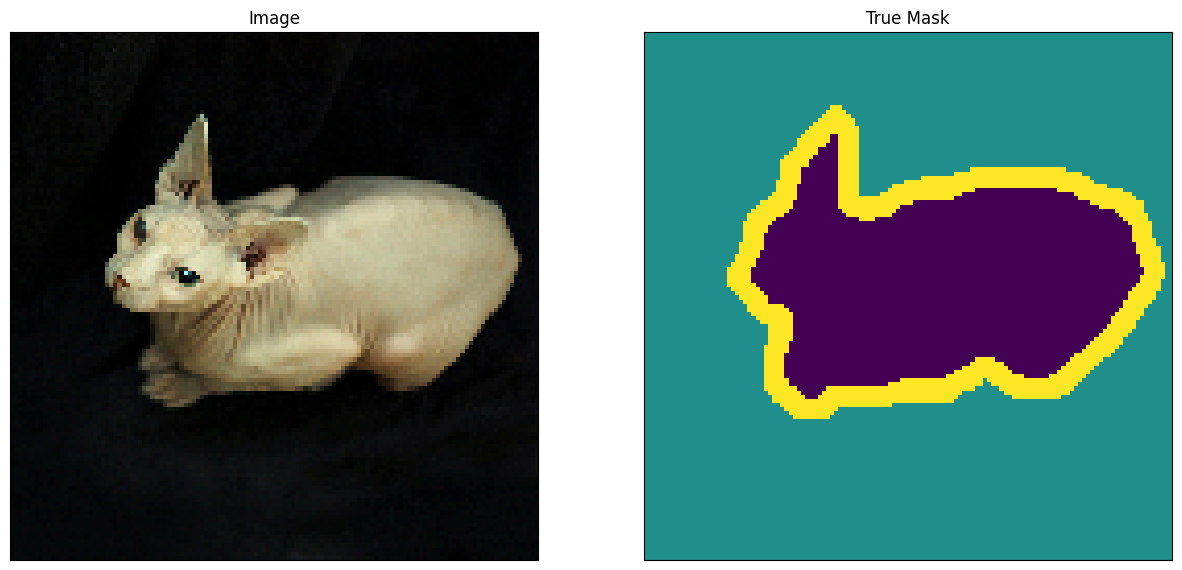

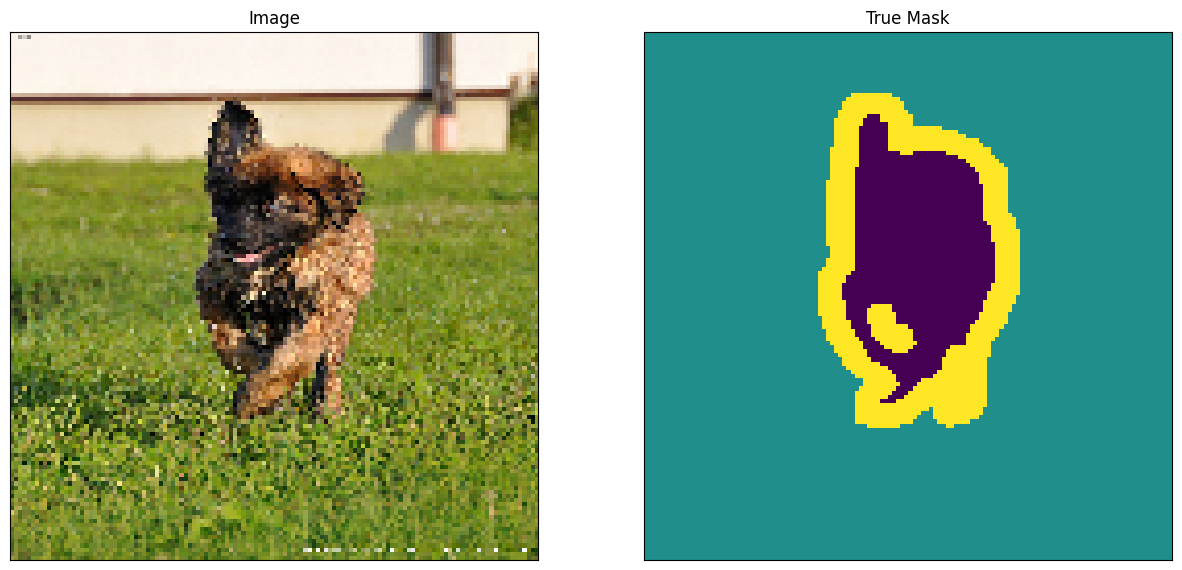

In [9]:
# Display an image from the train set
show_image_from_dataset(train)

# Display an image from the test set
show_image_from_dataset(test)

## Define the model

With the dataset prepared, you can now build the UNet. Here is the overall architecture as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

### Encoder

Like the FCN model you built in the previous lesson, the encoder here will have repeating blocks (red boxes in the figure below) so it's best to create functions for it to make the code modular. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. As discussed in class, each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [10]:
# Encoder Utilities
def conv2d_block(input_tensor,n_filters,kernel_size = 3):
  # First layer
  x = input_tensor

  for i in range(2):
    x = tf.keras.layers.Conv2D(
        filters = n_filters,
        kernel_size = (kernel_size,kernel_size),
        kernel_initializer = 'he_normal',
        padding = 'same'
    )(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x

def encoder_block(inputs,n_filters = 64,pool_size = (2,2),dropout = 0.3):
  f = conv2d_block(inputs,n_filters = n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f,p

def encoder(inputs):
  f1,p1 = encoder_block(inputs,n_filters = 64,pool_size = (2,2),dropout = 0.3)
  f2,p2 = encoder_block(p1,n_filters = 128,pool_size = (2,2),dropout = 0.3)
  f3,p3 = encoder_block(p2,n_filters = 256,pool_size = (2,2),dropout = 0.3)
  f4,p4 = encoder_block(p3,n_filters = 512,pool_size = (2,2),dropout = 0.3)

  return p4, (f1,f2,f3,f4)

### Bottleneck

In [11]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs,n_filters = 1024)
  return bottle_neck

### Decoder

Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [36]:
# Decoder Utilities

def decoder_block(inputs,conv_output,n_filters = 64,kernel_size = 3,strides = 3,dropout = 0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters,kernel_size,strides = strides,padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u,conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c,n_filters,kernel_size = 3)

  return c

def decoder(inputs,convs,output_channels):
  f1,f2,f3,f4 = convs

  c6 = decoder_block(inputs,f4,n_filters = 512,kernel_size = (3,3),strides = (2,2),dropout = 0.3)
  c7 = decoder_block(c6,f3,n_filters = 256,kernel_size = (3,3),strides = (2,2),dropout = 0.3)
  c8 = decoder_block(c7,f2,n_filters = 128,kernel_size = (3,3),strides = (2,2),dropout = 0.3)
  c9 = decoder_block(c8,f1,n_filters = 64,kernel_size = (3,3),strides = (2,2),dropout = 0.3)

  outputs = tf.keras.layers.Conv2D(output_channels,(1,1),activation = 'softmax')(c9)

  return outputs

### U-Net

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 128, 128, 64)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         36928     ['activation_18[0][0]']       
                                                                                            

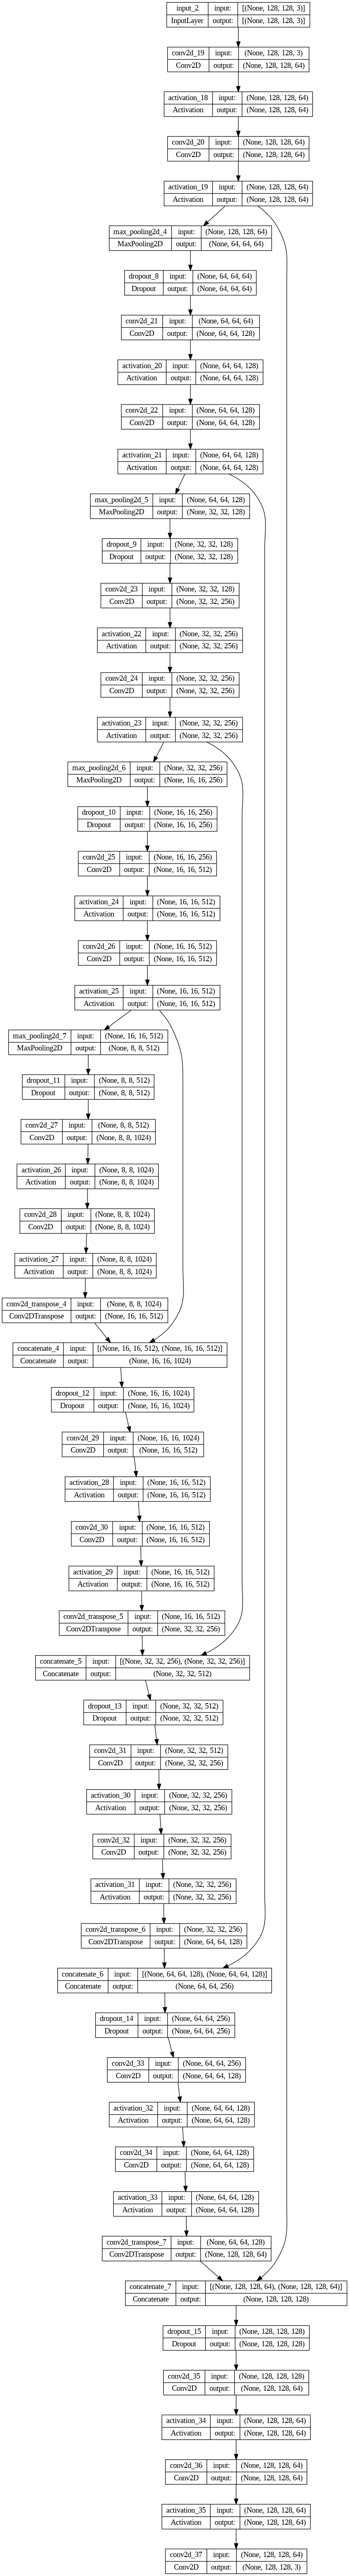

In [37]:
OUTPUT_CHANNELS = 3

def unet():
  # Specify the input shape
  inputs = tf.keras.layers.Input(shape = (128,128,3,))

  # Feed the input to the encoder
  encoder_output,conv = encoder(inputs)

  # feed th eencoder output to the bottlenect
  bottle_neck = bottleneck(encoder_output)

  # feed the botttleneck and encoder block outputs to the encoder
  outputs = decoder(bottle_neck,conv,output_channels = OUTPUT_CHANNELS)

  # Create the model
  model = tf.keras.Model(inputs = inputs,outputs = outputs)

  return model

# Instantiate the model
model = unet()
print(model.summary())
plot_model(model,show_shapes = True,show_layer_names = True)

# Compile and Train the model

In [38]:
# Configure the optimizer, loss and metrics for training
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [39]:
# Configure the training parameters and train the model
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = test_dataset
)

Epoch 1/10
57/57 [==============================] - 74s 1s/step - loss: 0.8948 - accuracy: 0.6234 - val_loss: 0.7401 - val_accuracy: 0.7106
Epoch 2/10
57/57 [==============================] - 65s 1s/step - loss: 0.7057 - accuracy: 0.7148 - val_loss: 0.6943 - val_accuracy: 0.7184
Epoch 3/10
57/57 [==============================] - 60s 1s/step - loss: 0.6371 - accuracy: 0.7410 - val_loss: 0.5971 - val_accuracy: 0.7592
Epoch 4/10
57/57 [==============================] - 61s 1s/step - loss: 0.5730 - accuracy: 0.7708 - val_loss: 0.5228 - val_accuracy: 0.7933
Epoch 5/10
57/57 [==============================] - 59s 1s/step - loss: 0.5383 - accuracy: 0.7877 - val_loss: 0.4878 - val_accuracy: 0.8076
Epoch 6/10
57/57 [==============================] - 58s 1s/step - loss: 0.4851 - accuracy: 0.8110 - val_loss: 0.4442 - val_accuracy: 0.8249
Epoch 7/10
57/57 [==============================] - 58s 1s/step - loss: 0.4532 - accuracy: 0.8237 - val_loss: 0.4299 - val_accuracy: 0.8340
Epoch 8/10
57/57 [==

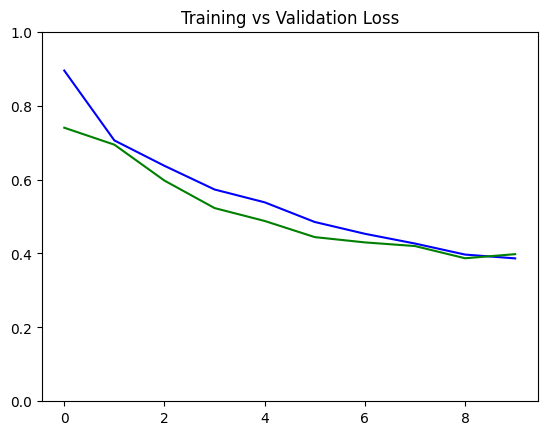

In [40]:
# Plot the training and validation loss
plot_metrics("loss",title = "Training vs Validation Loss",ylim = 1)

# Make Predictions

In [41]:
# Prediction utilities
def get_test_image_and_annotation_arrays():
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image,annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  # info.splits['test'].num_examples is 103.
  # BATCH_SIZE is 10.
  # 103 % 10 = 3
  # 103 - 3 = 100
  # So, [:100] ensures that only the first 100 examples are taken, which is a multiple of BATCH_SIZE.
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def create_mask(pred_mask):
  # tf.argmax(pred_mask, axis=-1) computes the index of the maximum value along the last axis.
  # This is typically used to convert a probability distribution (over classes) to a single class label.
  # For example, if pred_mask is of shape (batch_size, height, width, num_classes), the result of
  #  tf.argmax will have shape (batch_size, height, width).
  pred_mask = tf.argmax(pred_mask,axis = -1)
  # pred_mask[..., tf.newaxis] adds a new axis at the end, changing the shape from (batch_size, height, width)
  # to (batch_size, height, width, 1).
  # This operation is necessary because many image processing functions and models expect a 4-dimensional tensor
  # with a channel dimension, even if there is only one channel.
  pred_mask = pred_mask[...,tf.newaxis]
  # pred_mask[0] selects the first image in the batch, resulting in a tensor of shape (height, width, 1).
  # .numpy() converts the tensor to a NumPy array for further processing or visualization.
  return pred_mask[0].numpy()

def make_prediction(image,mask,num = 1):
  image = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# Compute class wise metrics

In [55]:
def class_wise_metrics(y_true,y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    dice_score = 2 * ( (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor) )
    class_wise_iou.append(iou)
    class_wise_dice_score.append(dice_score)

    return class_wise_iou,class_wise_dice_score

In [43]:
# Setup the ground truth and predictions

# get the ground truth from the test set
y_true_images,y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to the model to get the predicted mask
results = model.predict(test_dataset,steps = info.splits['test'].num_examples // BATCH_SIZE)
results = np.argmax(results,axis = 3)
results = results[...,tf.newaxis]

57/57 [==============================] - 16s 270ms/step


In [56]:
# Compute the IOU for each class
cls_wise_iou,cls_wise_dice_score = class_wise_metrics(y_true_segments,results)

In [57]:
# Display the iou for each class
for idx,iou in enumerate(cls_wise_iou):
  space = " " * (10 - len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx],space,iou))

pet         0.7188917704480758 


In [58]:
# Display the dice score for each class
for idx,dice_score in enumerate(cls_wise_dice_score):
  space = " " * (10 - len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx],space,dice_score))

pet         1.4377835408961517 


# Show Predictions

1/1 [==============================] - 0s 93ms/step


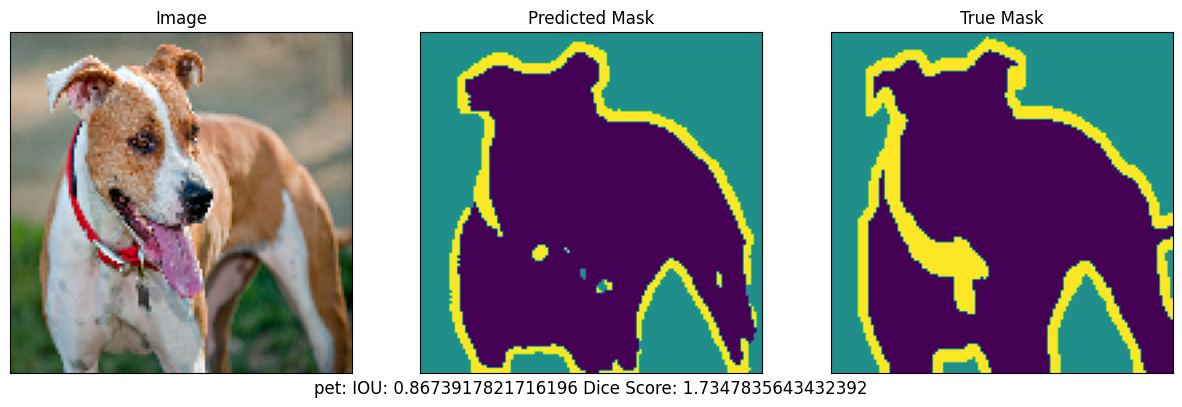

In [63]:
integer_sliders = [1,4,8,1000,3646]

for integer_slider in integer_sliders:
  # Get the prediction_mask
  y_pred_mask = make_prediction(y_true_images[integer_slider],y_true_segments[integer_slider])

  # Compute the class wise metrics
  iou,dice_score = class_wise_metrics(y_true_segments[integer_slider],y_pred_mask)

  # Overlay the metrics with the images
  display_with_metrics(
      [y_true_images[integer_slider],y_pred_mask,y_true_segments[integer_slider]],
      iou,
      dice_score
  )
  print()